In [1]:
from utilities.data_functions import col_to_edge_list, chromatic_numbers
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import WangLoss, PottsLoss, count_collisions, get_bad_edges
from utilities.helpers import get_device

device = get_device()
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4090


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from utilities.transformer_helpers import PositionalEncoding


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
#         deg = torch.sum(adj, dim=1)
#         out /= deg.view(-1, 1)
        out = self.W(out)
        return out


class JKColor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5, nheads=4):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, hidden_dim))

        for _ in range(num_layers - 1):
            self.layers.append(GraphConvolution(hidden_dim, hidden_dim))

        self.adj_normalized = None

        encoder_layers = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=1)
        self.positional_encoding = PositionalEncoding(d_model=hidden_dim)
        self.color = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        layer_outputs = []
        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
#             x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
            x = F.relu(x)
        x = torch.stack(layer_outputs, dim=0)  
        x = self.positional_encoding(x) 
        x = self.transformer_encoder(x)
        x = x[-1] 
        x = self.color(x) 
        return x

    def _make_adj(self, edge_index):
        adj = to_dense_adj(edge_index).squeeze(0).to(edge_index.device)
        self.adj_normalized = adj


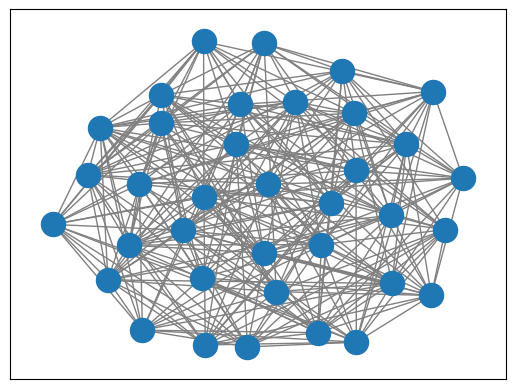

In [11]:
graph = 'queen6_6.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [12]:
print(model)

JKColor(
  (layers): ModuleList(
    (0): GraphConvolution(
      (W): Linear(in_features=16, out_features=32, bias=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (color): Sequential(
    (0): Linear(in_features=16, out_features

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

# Run the graph model
best_coloring = None
fewest_collisions = 10e5
results = []
cols = ['input_dim', 'hidden_dim', 'dropout', 'use_embedding', 'lr', 'layers', 'collisions']
patience = 1000

for in_dim in tqdm([16, 32, 64, 128, 256], desc='in_dim'):
    for hidden_dim in tqdm([32, 64, 128, 256], desc='dropout', leave=False):
        for dropout in tqdm([0.1, 0.2, 0.3], desc='hidden', leave=False):
            for use_embedding in tqdm([True, False], desc='use_embedding', leave=False):
                for lr in tqdm([5e-4, 1e-3, 5e-3], desc='lr', leave=False):
                    for layers in tqdm([1, 2, 3, 4, 5], desc='layers', leave=False):
                        input_dim = in_dim
                        output_dim = chromatic_numbers[graph]
                        num_layers = layers
                        epochs = 100000

                        model = JKColor(input_dim, hidden_dim, output_dim, num_layers, dropout=dropout).to(device)
                        edge_index = edge_list.to(device)
                        if use_embedding:
                            embeddings = nn.Embedding(n, input_dim).to(device)
                            graph_nodes = torch.arange(n).long().to(device)
                        else:
                            graph_rep = torch.randn((n, input_dim)).to(device)
                        if use_embedding:
                            optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
                        else:
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                        loss_fn = PottsLoss(edge_index)
        #                 loss_fn = WangLoss(edge_index, lam=.02)

                        prev_loss = 10e5
                        last_improvement = 0
                        for i in range(epochs):
                            if last_improvement > patience:
                                break
                            model.train()
                            optimizer.zero_grad()
                            if use_embedding:
                                graph_rep = embeddings(graph_nodes)
                            out = model(graph_rep, edge_index)
                            loss = loss_fn(out)
                            loss.backward()
                            optimizer.step()
                            if loss < prev_loss:
                                prev_loss = loss
                                last_improvement = 0
                            else:
                                last_improvement += 1
                            if i % 1000 == 0:
                                model.eval()
                                with torch.no_grad():
                                    out = model(graph_rep, edge_list)
                                coloring = torch.argmax(out, dim=1)
                                collisions = count_collisions(coloring, edge_list)
                                # print(f'{i}: {collisions, loss}')
                                if collisions == 0:
                                    best_coloring = coloring
                                    break
                                if collisions < fewest_collisions:
                                    fewest_collisions = collisions
                                    best_coloring = coloring

                        model.eval()
                        with torch.no_grad():
                            out = model(graph_rep, edge_list)
                        coloring = torch.argmax(out, dim=1)
                        collisions = count_collisions(coloring, edge_list)
                        results.append([in_dim, hidden_dim, dropout, use_embedding, lr, layers, collisions])



in_dim:   0%|          | 0/5 [00:00<?, ?it/s]

dropout:   0%|          | 0/4 [00:00<?, ?it/s]

hidden:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

layers:   0%|          | 0/5 [00:00<?, ?it/s]

66.0


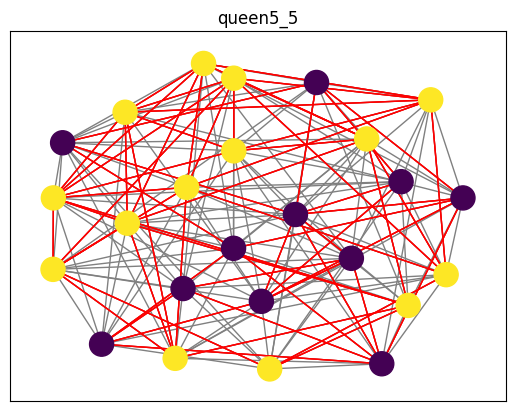

In [8]:
# Plot the colored graph
# 6_6: 1, 7_7: 6, 8_8: 5, 11_11: 26
bad_edges = get_bad_edges(best_coloring, edge_list)
print(len(bad_edges)/2)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])
